## XGB EVI Trend Break Magnitude Models - v1

Peter R., 2023-08-26

### Intro
I used DRAC server (Cedar) to run a few Extreme Gradient Boosting (XGB) models with Python. I used XGBRegression() to analyze forest EVI breaks (all breaks together, only negative & only positive breaks). The response variable was EVI tren break magnitudes and the predictors were around a dozen forest and climate variables.

Here I try to answer the question: What factors predict EVI Trend Break magnitude? 

Note that driver data was assigned via spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data. Hence, I have left out these variables. An important missing driver is likely tree windthrow (see Somerfield et al. 2018). I also left out percent conifer as well mositure variables given the  high correlation between these and percent deciduous and precipitation.

Here I manily explore and create visualizations of the models created with DRAC.

#### Positive breaks XGB model

Here I run positive breaks only.

In [1]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_pos_brks_v1.json")


C:\Users\Peter R\github\forc_trends\models\xgboost


In [52]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:24]

X1.drop(X1.columns[[2, 12, 14, 16, 18]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

#print(df2.describe)

In [6]:
#EVALUATION (with train and CV)
# all breaks
#Mean MAE: 370.861 (11.770)
#Mean MSE: 370.861 (11.770)
#Mean Var. Explained: 0.487 (0.025)
#R-sq: 0.486 (0.025)
#MSE: 318120.82
#RMSE: 564.02
#R-sq: 0.50
#Total time: 6682.17

# pos bp1
#Mean MAE: 221.324 (15.109)
#Mean MSE: 221.324 (15.109)
#Mean Var. Explained: 0.298 (0.062)
#R-sq: 0.292 (0.062)
#MSE: 108697.93
#RMSE: 329.69
#R-sq: 0.31
#Total time: 1790.18

# pos bp2
#MSE: 108697.93
#RMSE: 329.69
#R-sq: 0.31
#Total time: 5.22

Mean MAE: 220.499 (13.534)
Mean MSE: 220.499 (13.534)
Mean RMSE: 14.849 (3.679)
Mean Var. Explained: 0.310 (0.070)
R-sq: 0.305 (0.070)
MSE: 105226.33
RMSE: 324.39
R-sq: 0.33
Total time: 3756.35


#neg
#Mean MAE: 202.595 (6.349)
#Mean MSE: 202.595 (6.349)
#Mean Var. Explained: 0.360 (0.057)
#R-sq: 0.359 (0.057)
#MSE: 82562.94
#RMSE: 287.34
#R-sq: 0.36
#Total time: 4665.40


# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp1.evals_result()

mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

MSE: 108697.93
RMSE: 329.69
R-sq: 0.31


In [86]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
# retrieve performance metrics
results = model_bp1.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


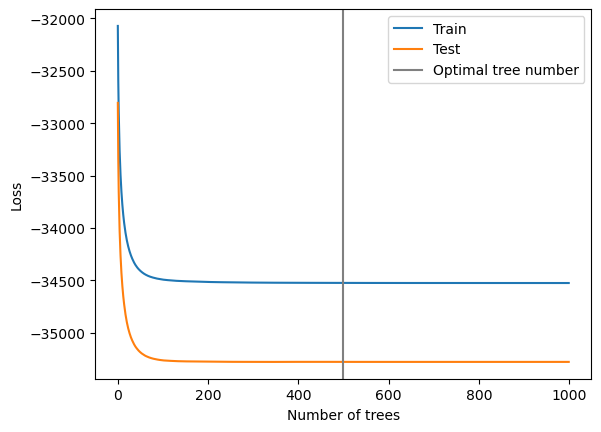

In [87]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.axvline(499, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

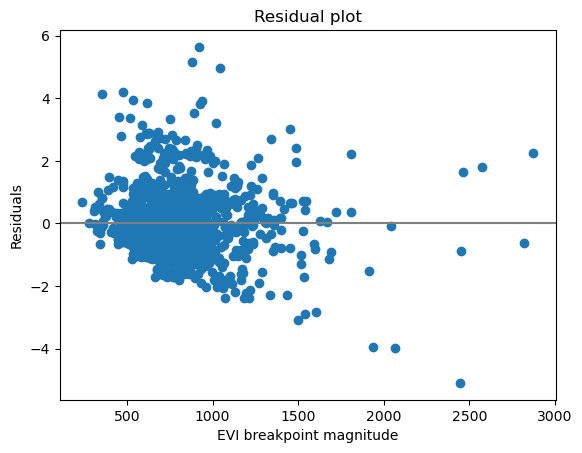

In [84]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

In [50]:
# Feature importance plot
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, weight', 
#                    xlabel='F score - weight', ylabel='Features', 
#                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.

# F score: This is a metric that simply sums up how many times each feature is split on

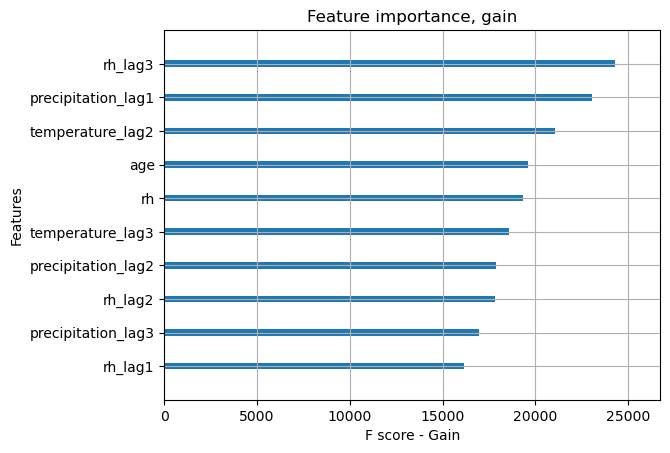

In [88]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\pos_gain6.png',  dpi=300, bbox_inches='tight')


pyplot.show()

In [51]:
# Plot, metric: total gain
#‘total_gain’: the total gain across all splits the feature is used in.
#xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, Total gain', 
#                    xlabel='F score - Total gain', ylabel='Features', 
#                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

#pyplot.savefig('total_gain6.png',  dpi=300, bbox_inches='tight')

#pyplot.show()

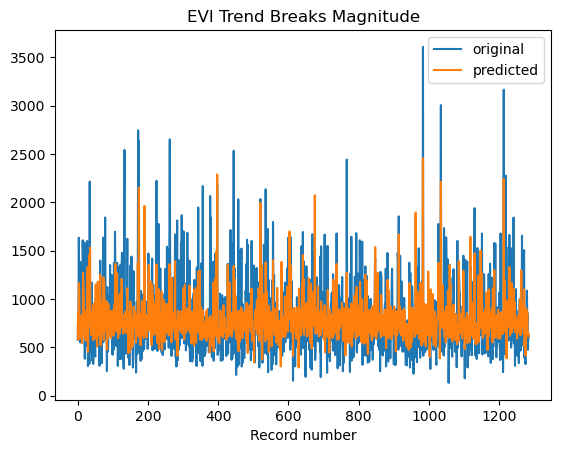

In [19]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

#plt.savefig('original_vs_predicted6.png',  dpi=300, bbox_inches='tight')


pyplot.savefig(r'.\figs\pos_predicted6.png',  dpi=300, bbox_inches='tight')

pyplot.show()

In [76]:
# Best parameters 2nd model

# Load model
# load saved model
model_bp2 = xgb.XGBRegressor()
model_bp2.load_model("model_bp2_pos_brks_v1.json")
model_bp2
#model_bp2.best_score
#model_bp2.best_iteration



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'int', 'float', 'float', 'int',
                            'float', 'int', 'float', 'int', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float'],
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp2.evals_result()

mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

#model_bp1
#MSE: 108697.93
#RMSE: 329.69
#R-sq: 0.31


MSE: 108697.93
RMSE: 329.69
R-sq: 0.31


In [56]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp2.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp2.predict(x1_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
# retrieve performance metrics
results = model_bp2.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


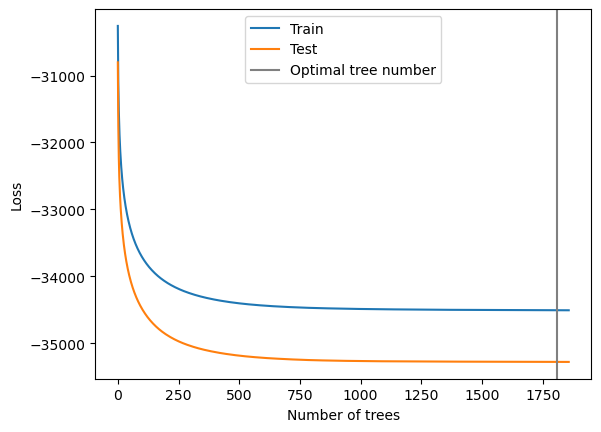

In [71]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
#pyplot.axvline(1807, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

In [ ]:
# Decision Tree plot
# this works for saving graphviz
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render(r'.\figs\pos_decision_tree6.png', format = format)


In [ ]:
# Partial dependence plots
# PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set.
from sklearn.inspection import PartialDependenceDisplay

#["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
#                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

features_names2 = ["age","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3"]
#target_names1 = "Magnitude"

_, ax1 = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(model_m2e, x1_train, features_names2, ax=ax1)

_ = display.figure_.suptitle(
    (
        "Partial dependence plots"
        
    ),
    fontsize=12,
)


plt.savefig(r'.\figs\partial_dependence6.png',  dpi=300, bbox_inches='tight')

plt.show()

# Black ticks on X-axis are deciles

#### Negative breaks XGB model

Here I run a model with negative breaks only

In [23]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_neg_brks_v1.json")

C:\Users\Peter R\github\forc_trends\models\xgboost


In [24]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_negative_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:24]

X1.drop(X1.columns[[2, 12, 14, 16, 18]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

In [25]:
#neg
#Mean MAE: 202.595 (6.349)
#Mean MSE: 202.595 (6.349)
#Mean Var. Explained: 0.360 (0.057)
#R-sq: 0.359 (0.057)

#MSE: 82562.94
#RMSE: 287.34
#R-sq: 0.36
#Total time: 4665.40

# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp1.evals_result()

mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

MSE: 82562.94
RMSE: 287.34
R-sq: 0.36


In [27]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
# retrieve performance metrics
results = model_bp1.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

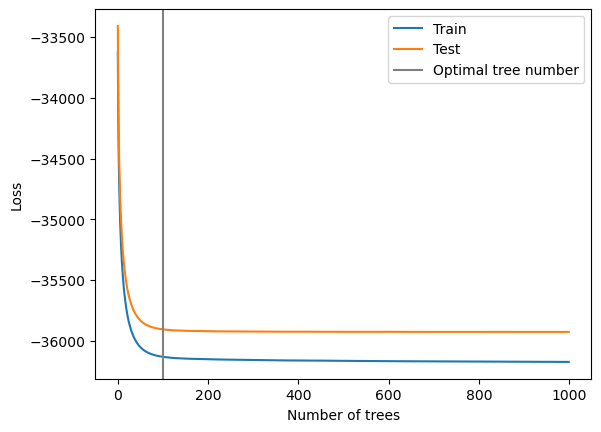

In [30]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.axvline(100, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

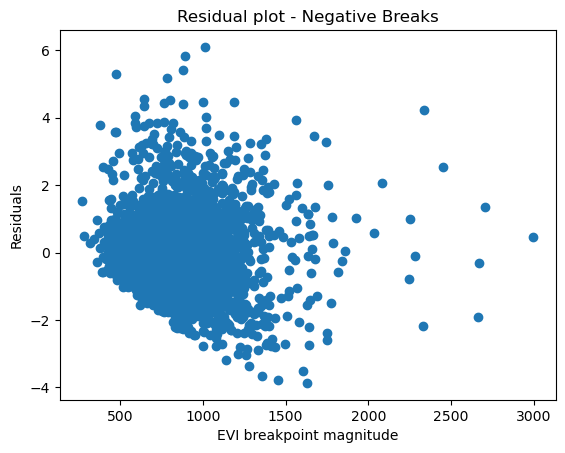

In [31]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot - Negative Breaks')

pyplot.show()


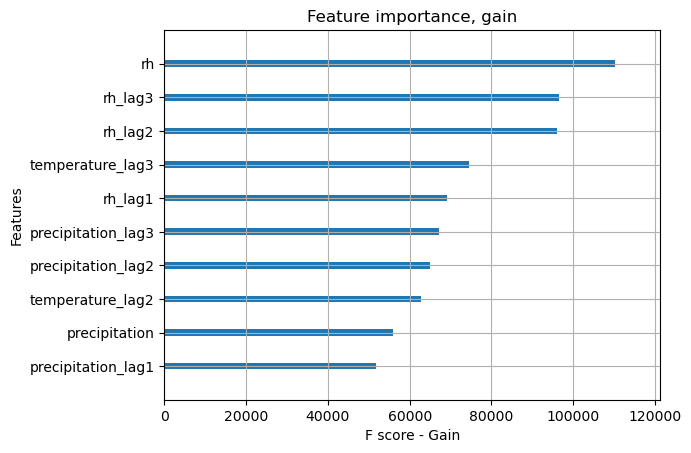

In [32]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\neg_gain6.png',  dpi=300, bbox_inches='tight')


pyplot.show()

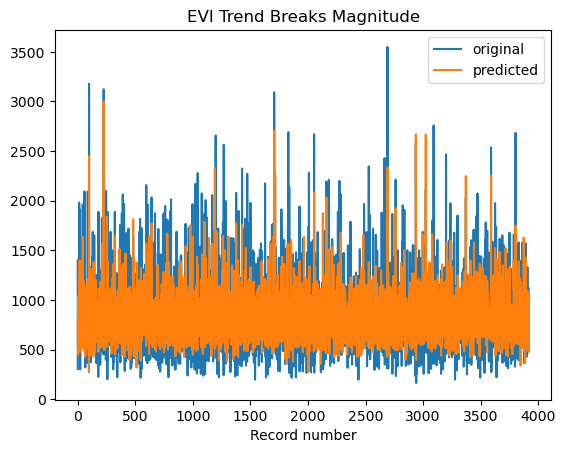

In [33]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

pyplot.savefig(r'.\figs\neg_predicted6.png',  dpi=300, bbox_inches='tight')

pyplot.show()

#### All breaks (negative & positive) XGB model

In [38]:
import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Get the current working directory
cwd = os.getcwd()

print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")


# Load model
# load saved model
model_bp1 = xgb.XGBRegressor()
model_bp1.load_model("model_bp1_all_brks_v1.json")

C:\Users\Peter R\github\forc_trends\models\xgboost


In [48]:
model_bp1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'int', 'float', 'float', 'int',
                            'float', 'int', 'float', 'int', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float'],
             gamma=0.05, gp...=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_v1.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v1.csv', skipinitialspace=True)
#df1.head()

df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)

df2= df2[df2['precipitation'].notna()]

X1 = df2.iloc[:,2:24]

X1.drop(X1.columns[[2, 12, 14, 16, 18]], axis=1,inplace=True)

y1 = df2.iloc[:,1]


features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag1", "temperature_lag1", "precipitation_lag2", "temperature_lag2", "precipitation_lag3", "temperature_lag3",
                 "rh" ,"rh_lag1","rh_lag2","rh_lag3"]

seed = 7 # random seed to help with replication
testsize1 = 0.33 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

In [40]:
#EVALUATION (with train and CV)
# all breaks
#Mean MAE: 370.861 (11.770)
#Mean MSE: 370.861 (11.770)
#Mean Var. Explained: 0.487 (0.025)
#R-sq: 0.486 (0.025)

#MSE: 318120.82
#RMSE: 564.02
#R-sq: 0.50
#Total time: 6682.17


# EVALUATION (with test)
eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model_bp1.evals_result()

mse = mean_squared_error(y1_test, y_pred)
#r2 = explained_variance_score(y1_test, ypred)
r2 = r2_score(y1_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

print("R-sq: %.2f" % r2)

MSE: 318120.82
RMSE: 564.02
R-sq: 0.50


In [41]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
#UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
model_bp1.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model_bp1.predict(x1_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
# retrieve performance metrics
results = model_bp1.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


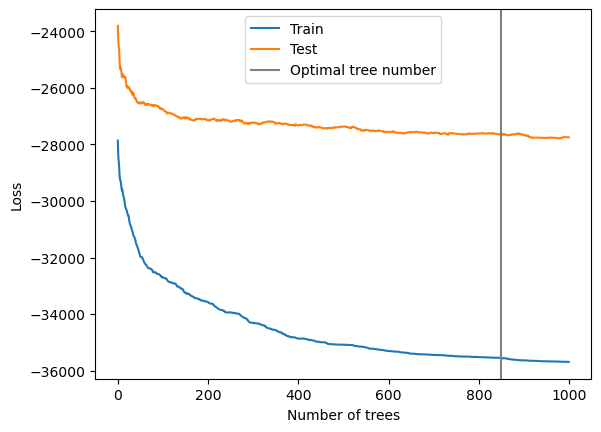

In [44]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
pyplot.axvline(850, color="gray", label="Optimal tree number")
pyplot.xlabel("Number of trees")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()
# This plot tells me I should run another model limiting the number of trees

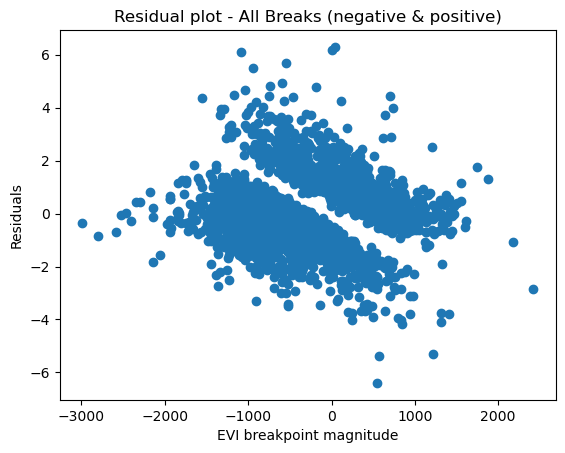

In [45]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot - All Breaks (negative & positive)')

pyplot.show()

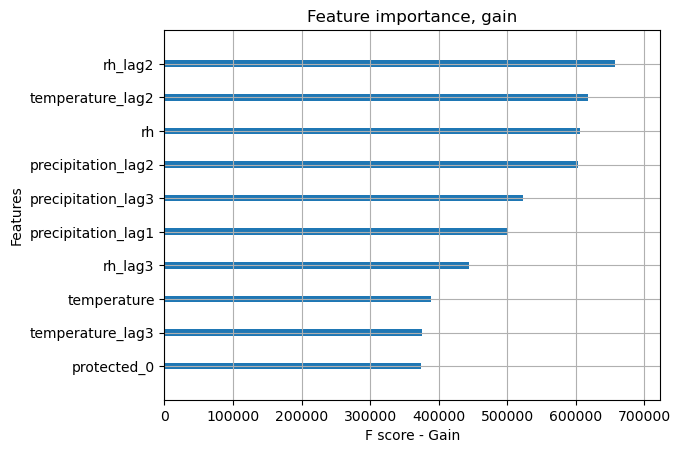

In [46]:
# Plot, metric: gain
#‘gain’: the average gain across all splits the feature is used in.
xgb.plot_importance(model_bp1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

pyplot.savefig(r'.\figs\all_gain6.png',  dpi=300, bbox_inches='tight')


pyplot.show()

In [ ]:
# this works for saving graphviz
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp1, num_trees = model_m2e.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (work only if format == 'png')
#image.graph_attr = {'dpi':'300'}

#image.render('decision_tree5', format = format)

#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

https://scikit-learn.org/stable/modules/partial_dependence.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#way-partial-dependence-with-different-models

https://mljar.com/blog/xgboost-early-stopping/

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://github.com/parrt/dtreeviz



